In [ ]:
from pprint import pprint
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [ ]:
import re
import datetime
from pyspark.sql import Row

month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

def apache_time(s):
   return datetime.datetime(
      int(s[7:11]),
      month_map[s[3:6]],
      int(s[0:2]),
      int(s[12:14]),
      int(s[15:17]),
      int(s[18:20]))

In [ ]:
# (1a) Parsing Each Log Line
def parse_apache_log_line(logline):
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None: return (logline, 0)
    return (Row(
        host = match.group(1),
        client_id = match.group(2),
        user_id = match.group(3),
        date_time = apache_time(match.group(4)),
        method = match.group(5),
        endpoint = match.group(6),
        protocol = match.group(7),
        response_code = int(match.group(8)),
        content_size = int(match.group(9)) if match.group(9) != '-' else 0), 1)

In [ ]:
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [ ]:
from google.colab import drive
drive.mount('/content/modules', force_remount=True)

Mounted at /content/modules


In [ ]:
# (1b) Configuration and Initial RDD Creation
logFile = "/content/modules/My Drive/NASAlog.txt"
def parseLogs():
    parsed_logs = sc.textFile(logFile).map(parse_apache_log_line).cache()
    access_logs = parsed_logs.filter(lambda s: s[1] == 1).map(lambda s: s[0]).cache()
    failed_logs = parsed_logs.filter(lambda s: s[1] == 0).map(lambda s: s[0])
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print('Number of invalid loglines: %d' % failed_logs.count())
        for line in failed_logs.take(20):
            print('Invalid logline: %s' % line)
    print('Read %d lines, successfully parsed %d lines, failed to parse %d lines'
        % (parsed_logs.count(), access_logs.count(), failed_logs.count()))
    return parsed_logs, access_logs, failed_logs
parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid loglines: 58
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:09:27 -0400] "GET / /   HTTP/1.0" 200 7074
Invalid logline: wxs6-7.worldaccess.nl - - [02/Jul/1995:08:11:20 -0400] "GET / /facts/facts.html HTTP/1.0" 200 7074
Invalid logline: s29.abqslip.indirect.com - - [02/Jul/1995:14:24:26 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 7020
Invalid logline: pipe3.nyc.pipeline.com - - [02/Jul/1995:22:24:41 -0400] "GET /shuttle/countdown/dy �?shuttle%20tracking HTTP/1.0" 404 -
Invalid logline: pipe3.nyc.pipeline.com - - [02/Jul/1995:22:25:48 -0400] "GET /shuttle/countdown/dy �?tracking%20station HTTP/1.0" 404 -
Invalid logline: wxs6-4.worldaccess.nl - - [03/Jul/1995:08:14:40 -0400] "GET / /   HTTP/1.0" 304 0
Invalid logline: atl4-m52.ed.ac.uk - - [03/Jul/1995:09:31:12 -0400] "GET /images/NASA-logosmall.gif align=left HTTP/1.0" 200 786
Invalid logline: atl4-m52.ed.ac.uk - - [03/Jul/1995:09:32:20 -0400] "GET /images/NASA-logosmall.gif align=left HTTP/1.0" 20

In [ ]:
# (1c) Data Cleaning
APACHE_ACCESS_LOG_PATTERN = (
    r"^([^ ]+)" # host
    r" ([^ ]+)" # client_id
    r" ([^ ]+)" # user_id
    r" \[([^]]*)\]" # date_time
    r" \"(GET|HEAD|POST)" # method, r' "(\S+)'
    r" ([^ ]+)" # endpoint, r' (\S*)'
    r"(?:[ ]*[^ ]+[ ]*)*?" # r'( *\S+ *)*'
    r"( HTTP/(?:V|)1.0|)" # protocol
    r"\" ([0-9]+)" # response_code
    r" ([0-9]+|-)" # content_size
    r"$"
)
log_lines = 0
failed_lines = 0
with open(logFile, encoding="latin1") as log_file:
    while log_line := log_file.readline():
        log_line = log_line[:-1]
        match = re.search(APACHE_ACCESS_LOG_PATTERN, log_line)
        if not match: failed_lines += 1
        log_lines += 1
print(log_lines, failed_lines)

314876 0


In [ ]:
parsed_logs, access_logs, failed_logs = parseLogs()

Read 314876 lines, successfully parsed 314876 lines, failed to parse 0 lines


In [ ]:
# (2a) Example: Content Size Statistics
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print('Content Size Avg: %i, Min: %i, Max: %s'
    % (content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
       content_sizes.min(),
       content_sizes.max()))

Content Size Avg: 23542, Min: 0, Max: 2973350


In [ ]:
# (2b) Example: Response Code Analysis
response_code_to_count = (
    access_logs
    .map(lambda log: (log.response_code, 1))
    .reduceByKey(lambda a, b : a + b)
    .cache())
response_code_to_countList = response_code_to_count.take(100)
print('Found %d response codes' % len(response_code_to_countList))
print('Response Code Counts: %s' % response_code_to_countList)

Found 7 response codes
Response Code Counts: [(200, 283992), (304, 17842), (302, 11354), (404, 1621), (500, 53), (403, 13), (501, 1)]


[200, 304, 302, 404, 500, 403, 501]
[0.9019169450831438, 0.05666357550273759, 0.03605863895628755, 0.005148058283260712, 0.00016832022764516825, 4.1286093573343156e-05, 3.1758533517956276e-06]


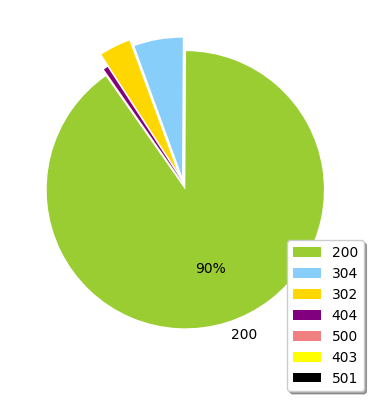

In [ ]:
# (2c) Example: Response Code Graphing with matplotlib
import matplotlib.pyplot as plt
labels = response_code_to_count.map(lambda r: r[0]).collect()
print(labels)
count = access_logs.count()
fracs = response_code_to_count.map(lambda r: (float(r[1]) / count)).collect()
print(fracs)
def pie_pct_format(value):
    return '' if value < 7 else '%.0f%%' % value
fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(
    fracs, labels=labels, colors=colors,
    explode=explode, autopct=pie_pct_format,
    shadow=False, startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('') # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
#display(fig)

In [ ]:
# (2d) Example: Frequent Hosts
host_count_pair_tuple = access_logs.map(lambda log: (log.host, 1))
host_sum = host_count_pair_tuple.reduceByKey(lambda a, b : a + b)
host_more_than_10 = host_sum.filter(lambda s: s[1] > 10)
hosts_pick_20 = host_more_than_10.map(lambda s: s[0]).take(20)
print('Any 20 hosts that have accessed more than 10 times: %s' % hosts_pick_20)

Any 20 hosts that have accessed more than 10 times: ['j10.ptl5.jaring.my', 'freenet.edmonton.ab.ca', 'www-a1.proxy.aol.com', '129.188.154.200', 'www-d1.proxy.aol.com', 'www-b2.proxy.aol.com', 'ip109.phx.primenet.com', 'foley.ripco.com', 'remote14.compusmart.ab.ca', 'tularcitos.tularcitos.cusd.k12.ca.us', 'ppp179.iadfw.net', 'ip16-004.phx.primenet.com', 'www-d2.proxy.aol.com', 'alyssa.prodigy.com', 'gateway.ps.net', 'www-b4.proxy.aol.com', 'piweba1y.prodigy.com', 'world.std.com', '139.169.183.30', 'slip80.slip.pacifier.com']


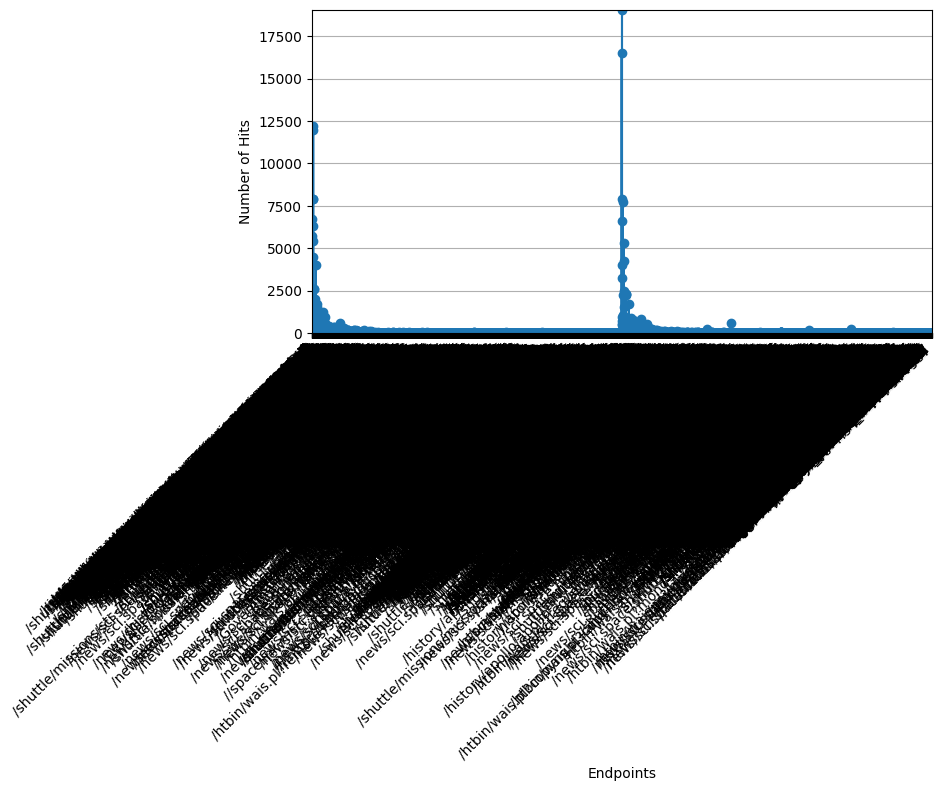

In [ ]:
# (2e) Example: Visualizing Endpoints
endpoints = access_logs.map(lambda log: (log.endpoint, 1)).reduceByKey(lambda a, b: a + b).cache()
ends = endpoints.map(lambda e: e[0]).collect()
counts = endpoints.map(lambda e: e[1]).collect()
fig, ax = plt.subplots(figsize=(8, 4.2), facecolor='white', edgecolor='white')
ax.set_xticks(range(len(ends)))
ax.set_xticklabels(ends, rotation=45, ha="right")
ax.set_xlim([0, len(ends)])
ax.set_ylim([0, max(counts)])
ax.grid(True, which='major', axis='y')
ax.set_xlabel("Endpoints")
ax.set_ylabel("Number of Hits")
ax.plot(range(len(ends)), counts, marker="o", linestyle="-")
plt.show()

In [ ]:
# (2f) Example: Top Endpoints
endpoint_counts = access_logs.map(lambda log: (log.endpoint, 1)).reduceByKey(lambda a, b : a + b)
top_endpoints = endpoint_counts.takeOrdered(10, lambda s: -1 * s[1])
print('Top Ten Endpoints: %s' % top_endpoints)

Top Ten Endpoints: [('/images/NASA-logosmall.gif', 19065), ('/images/KSC-logosmall.gif', 16502), ('/shuttle/countdown/count.gif', 12230), ('/shuttle/countdown/', 11992), ('/images/MOSAIC-logosmall.gif', 7912), ('/images/ksclogo-medium.gif', 7902), ('/images/USA-logosmall.gif', 7887), ('/images/WORLD-logosmall.gif', 7729), ('/shuttle/missions/sts-71/images/images.html', 6718), ('/shuttle/missions/sts-71/sts-71-patch-small.gif', 6628)]


In [ ]:
# (3a) Exercise: Top Ten Error Endpoints
# What are the top ten endpoints which did not have return code 200?
# Create a sorted list containing top ten endpoints.
# Include the number of times they were accessed with non-200 return code.
not_200 = access_logs.filter(lambda log: log.response_code != 200)
endpoint_count_pair_tuple = not_200.map(lambda log: (log.endpoint, 1))
endpoint_sum = endpoint_count_pair_tuple.reduceByKey(lambda acc, count: acc + count)
top_ten_err_URLs = endpoint_sum.takeOrdered(10, lambda e: -e[1])
print(endpoint_sum.count())
print('Top Ten failed URLs: %s' % top_ten_err_URLs)

4690
Top Ten failed URLs: [('/images/NASA-logosmall.gif', 2404), ('/images/KSC-logosmall.gif', 1806), ('/shuttle/countdown/', 944), ('/images/MOSAIC-logosmall.gif', 845), ('/images/USA-logosmall.gif', 830), ('/images/WORLD-logosmall.gif', 811), ('/shuttle/countdown/count.gif', 777), ('/images/ksclogo-medium.gif', 751), ('/shuttle/countdown/liftoff.html', 590), ('/shuttle/missions/sts-71/sts-71-patch-small.gif', 543)]


In [34]:
# (3b) Exercise: Number of Unique Hosts
# How many unique hosts are there in the entire log?
hosts = access_logs.map(lambda log: (log.host, 1))
unique_hosts = hosts.groupByKey()
unique_hosts_count = unique_hosts.count()
print('Unique hosts: %d' % unique_hosts_count)

Unique hosts: 22013


In [57]:
# (3c) Exercise: Number of Unique Daily Hosts
# How many unique hosts are there in the entire log on a day-by-day basis.
day_to_host_pair_tuple = access_logs.map(lambda log: (log.date_time.day, {log.host}))
day_grouped_hosts = day_to_host_pair_tuple.reduceByKey(lambda accum, value: accum.union(value))
day_host_count = day_grouped_hosts.map(lambda item: (item[0], len(item[1])))
daily_hosts = day_host_count
daily_hosts.cache()
daily_hosts_list = daily_hosts.takeOrdered(4)
print('Unique hosts per day: %s' % daily_hosts_list)

Unique hosts per day: [(2, 4859), (3, 7336), (4, 5524), (5, 7383)]


[2, 3, 4, 5]
[4859, 7336, 5524, 7383]


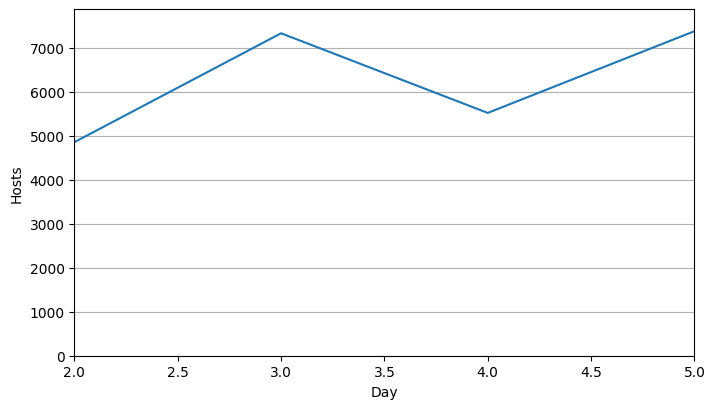

In [76]:
# (3d) Exercise: Visualizing the Number of Unique Daily Hosts
days_with_hosts = daily_hosts.sortBy(lambda item: item[0]).map(lambda item: item[0]).collect()
hosts           = daily_hosts.sortBy(lambda item: item[0]).map(lambda item: item[1]).collect()
print(days_with_hosts)
print(hosts)
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(days_with_hosts), max(days_with_hosts), 0, max(hosts)+500])
plt.grid(which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(days_with_hosts, hosts)